# **Convolutional Neural Networks and Leaf Disease Classification**

## By Jacob Briones
---

In this project on Convolutional Neural Networks, we explored the idea of convolution (filtering images) and how it can be used to trin a neural network which is capable of classifying images into a certain number of classes. In this project, we use a Convolutional Neural Network to predict certain types of plant diseases which may be present on leaves. 

---

# The Dataset

The [Beans Leaf Image Dataset](https://huggingface.co/datasets/AI-Lab-Makerere/beans) is a dataset containing images of bean leaves into one of the three different classes:
* 2: Healthy
* 1: Have [Bean Rust](https://ipm.cahnr.uconn.edu/bean-rust/#:~:text=Bean%20rust%20is%20caused%20by,favorable%20early%20in%20the%20season.)
* 0: Have [Angular Leaf Spot](https://extension.umn.edu/disease-management/angular-leaf-spot#:~:text=Angular%20leaf%20spot%20is%20a,thrives%20in%20warm%20humid%20conditions.)

Using the `datasets` library in python, we load the dataset into the variable `dataset`

In [1]:
from datasets import load_dataset
import datasets
dataset = load_dataset("beans")

Our dataset contains a **[dictionary](https://docs.python.org/3/tutorial/datastructures.html#dictionaries)** containing three seperate datasets within it. 
* `train dataset`: containing 1,034 elements
* `validation dataset`: containing 133 elements
* `test dataset`: containing 128 elements

Each dataset contains the same three features:
* `'image_file_path'`: location of the image
* `'image'`: The actual image 
* `'labels'`: Label for the image


IMAGE FILE PATH:
/home/albert/.cache/huggingface/datasets/downloads/extracted/967f0d9f61a7a8de58892c6fab6f02317c06faf3e19fba6a07b0885a9a7142c7/train/healthy/healthy_train.193.jpg

IMAGE LABEL:
2

IMAGE:


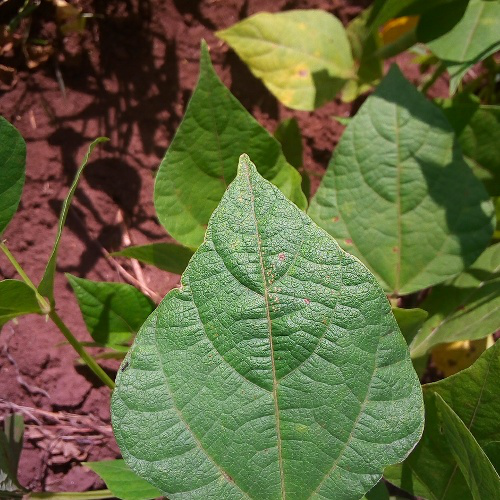

In [2]:
print('\nIMAGE FILE PATH:\n'+str(dataset['train'][797]['image_file_path']))
print("\nIMAGE LABEL:\n"+str(dataset['train'][797]['labels']))
print("\nIMAGE:")

dataset['train'][797]['image']

## Converting the data to an array

We want to convert the images and labels into arrays. The images we will convert to `numpy` arrays with three color channels, and the labels will be converted into an array containing integers between 0 and 2 representing the class label. 

In [3]:
import numpy as np

train_images = np.array([dataset["train"][i]["image"] for i in range(len(dataset['train']))])
train_labels= np.array([dataset["train"][i]["labels"] for i in range(len(dataset['train']))])

val_images = np.array([dataset["validation"][i]["image"] for i in range(len(dataset['validation']))])
val_labels = np.array([dataset["validation"][i]["labels"] for i in range(len(dataset['validation']))])

test_images = np.array([dataset["test"][i]['image'] for i in range(len(dataset["test"]))])
test_labels = np.array([dataset["test"][i]['labels'] for i in range(len(dataset['test']))])

In [4]:
print("\nShape of train_images: {}\nShape of train_labels: {}\n".format(train_images.shape, train_labels.shape))
print("Shape of test_images: {}\nShape of test_labels: {}\n".format(test_images.shape, test_labels.shape))
print("Shape of val_images: {}\nShape of val_labels: {}".format(val_images.shape, val_labels.shape))


Shape of train_images: (1034, 500, 500, 3)
Shape of train_labels: (1034,)

Shape of test_images: (128, 500, 500, 3)
Shape of test_labels: (128,)

Shape of val_images: (133, 500, 500, 3)
Shape of val_labels: (133,)


## Formatting the data

Using the [`albumentations`](https://github.com/albumentations-team/albumentations) library, we define a composition of image transformations to help format each image. 
The transformations applied are as follows:

* `RandomCrop(width=256, height=256)`: This will crop the image to a random location of the image having width and height of 256.
* `HorizontalFlip(p=0.5)`: This will flip the image horizontally with probability of 0.5. 
* `RandomBrightnessContrast(p=0.2)`: This will apply an adjustment to the brightness and contrast of the image with probability of 0.2.



In [5]:
import albumentations

In [6]:
transform = albumentations.Compose([
    albumentations.RandomCrop(width=256, height=256),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.RandomBrightnessContrast(p=0.2),
])

In [7]:
# Applies transform to each image and returns an arrray of transformed images
def transforms(examples):
    examples = np.array([transform(image=example)['image'] for example in examples])
    return examples

In [8]:
train_images = transforms(train_images)
test_images = transforms(test_images)
val_images = transforms(val_images)

### Normalizing and Changing Datatype:
Usually, pixel values are stored as 8-bit integers (`uint8`) having values between 0 and 255. We need to convert these pixel values to 32-bit floating point numbers between 0 and 1

In [9]:
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0
val_images = val_images.astype('float32') / 255.0

In [10]:
print('Max Pixel Value: {}\nMin Pixel Value: {}\nDatatype: {}'.format(train_images.max(), train_images.min(), train_images.dtype))

Max Pixel Value: 1.0
Min Pixel Value: 0.0
Datatype: float32


## Storing information into variables

In [11]:
num_train_images = train_images.shape[0]
train_image_width, train_image_height = train_images.shape[1], train_images.shape[1]
train_image_channels = train_images.shape[-1]

num_train_images = test_images.shape[0]
test_image_width, test_image_height = test_images.shape[1], test_images.shape[1]
test_image_channels = test_images.shape[-1]

In [12]:
print("\nShape of train_images: {}\nShape of train_labels: {}\n".format(train_images.shape, train_labels.shape))
print("Shape of test_images: {}\nShape of test_labels: {}\n".format(test_images.shape, test_labels.shape))
print("Shape of val_images: {}\nShape of val_labels: {}".format(val_images.shape, val_labels.shape))


Shape of train_images: (1034, 256, 256, 3)
Shape of train_labels: (1034,)

Shape of test_images: (128, 256, 256, 3)
Shape of test_labels: (128,)

Shape of val_images: (133, 256, 256, 3)
Shape of val_labels: (133,)


## Shuffling the Data for better Training
To ensure better model accuracy, we need to make sure that images of different classes appear in a random order. For this, we use the `shuffle` function from `scikitlearn.utils`

In [13]:
from sklearn.utils import shuffle
train_images, train_labels = shuffle(train_images, train_labels)
test_images, test_labels = shuffle(test_images, test_labels)
val_images, val_labels = shuffle(val_images, val_labels)

In [14]:
from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(train_labels)
val_labels = to_categorical(val_labels)
test_labels = to_categorical(test_labels)

## Viewing the Dataset

In [15]:
import matplotlib.pyplot as plt

Below, we can see an array of 25 different images, along with the class they are associated with.

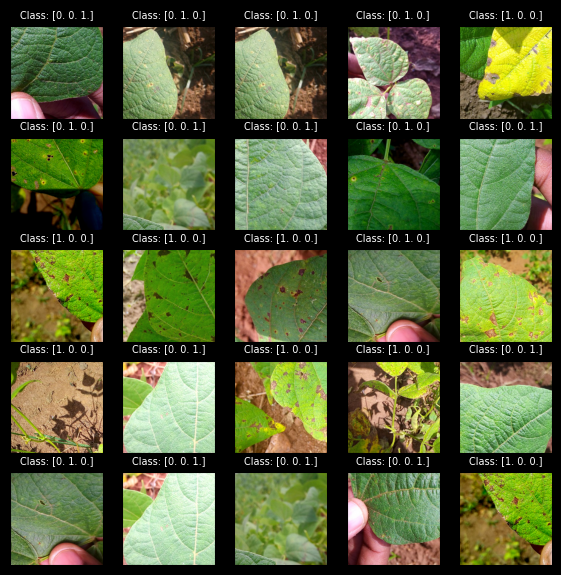

In [16]:
fig, ax = plt.subplots(5,5, figsize=(7,7))
fig.set_facecolor('black')
for i in range(5):
    for j in range(5):
        ind = np.random.randint(0,num_train_images)
        ax[i][j].imshow(train_images[ind])
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        ax[i][j].set_title('Class: {}'.format(train_labels[ind]),color='white',size=7)

### Viewing different Color Channels
Below, we can see the different color channels (RGB), and the effect of adding together any two of them. Below, we use the library `cv2` to split the 45th image in the training set into three different color channels `[R,G,B]`. Each image is 256 by 256 pixels. We reformat the red, green, and blue images so that they have shape `(256,263,3)` with two color channels that have zeros in them.

In [17]:
import cv2 as cv
ind = np.random.randint(0,num_train_images)
example_image = train_images[ind]
zeros = np.zeros((256,256,1))
[R,G,B] = cv.split(example_image)

# Zeros in the Green and Blue color channels
R = np.expand_dims(R,-1)
R = np.dstack([R,zeros,zeros])

# Zeros in the Red and Blue color channels
G = np.expand_dims(G,-1)
G = np.dstack([zeros,G,zeros])

# Zeros in the Red and Green Color channels
B = np.expand_dims(B,-1)
B = np.dstack([zeros,zeros,B])

# Store into a list
colors = [R,G,B, R+G,G+B,B+R, R+B,G+R,B+G]
color_labels = ['R','G','B','R+G','G+B','B+R','R+B','G+R','B+G']

Below, we use the `matplotlib.pyplot` library to plot the different colored images using the `imshow` function.

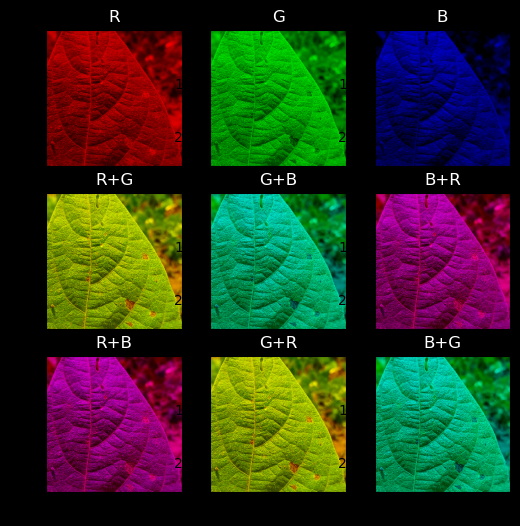

In [18]:
fig, ax = plt.subplots(3,3,figsize=(6,6))
fig.set_facecolor('black')
for i in range(3):
    for j in range(3):
        ax[i][j].imshow(colors[3*i +j])
        ax[i][j].set_title(color_labels[3*i+j],color='white')

# Convolutional Neural Networks

## Filters

Convolutional neural networks work by updating the **filters** which the images are convolved with. Below are two types of examples of filters applied to an image. 

In [340]:
from cv2 import filter2D, Laplacian, Sobel, filter2D

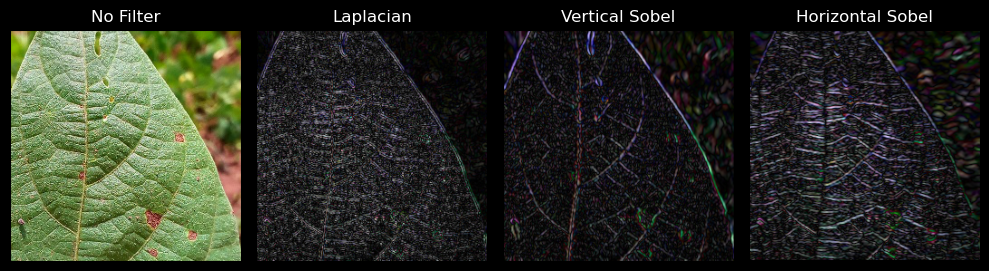

In [180]:
laplace = Laplacian(example_image,ddepth=-1,ksize=5)
sobel_h = Sobel(example_image, ksize=5, ddepth=-1,dx=1,dy=0)
sobel_v = Sobel(example_image, ksize=5, ddepth=-1,dx=0,dy=1)

fig, ax = plt.subplots(1,4,figsize=(10,5))
filter_labels = ['No Filter','Laplacian', 'Vertical Sobel', 'Horizontal Sobel']
fig.set_facecolor('black')
for i in range(4):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(filter_labels[i],color='white')
ax[0].imshow(example_image)
ax[1].imshow(np.abs(laplace)/np.abs(laplace).max())
ax[2].imshow(np.abs(sobel_h)/np.abs(sobel_h).max())
ax[3].imshow(np.abs(sobel_v)/np.abs(sobel_v).max())
plt.tight_layout()
plt.show()

## Training a CNN using `tensorflow.keras`

Using the `keras` library, we construct a convolutional neural network consisting of the following layers:

In [603]:
from tensorflow.keras import models
from tensorflow.keras import layers
import tensorflow as tf

model = models.Sequential()

In [604]:
model.add(layers.Conv2D(32, (5,5), activation='relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(rate=0.3))
model.add(layers.Dense(3,activation='softmax'))

In [605]:
model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [606]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 252, 252, 32)      2432      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 126, 126, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 122, 122, 32)      25632     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 61, 61, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (None, 59, 59, 32)        9248      
                                                                 
 flatten_13 (Flatten)        (None, 111392)          

In [ ]:
history = model.fit(train_images, train_labels, epochs=15, 
                    validation_data=(val_images, val_labels),shuffle=True)

Epoch 1/15
33/33 [==============================] - 23s 629ms/step - loss: 1.7045 - accuracy: 0.3714 - val_loss: 1.0544 - val_accuracy: 0.4887
Epoch 2/15
24/33 [====================>.........] - ETA: 4s - loss: 1.1251 - accuracy: 0.3997

In [311]:
model.save('leaves_cnn.h5')

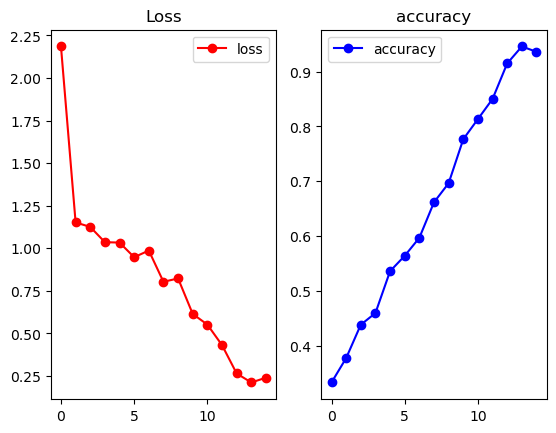

In [312]:
fig, ax = plt.subplots(1,2)
ax[0].plot([i for i in range(15)], history['loss'],'-ro')
ax[0].set_title('Loss',)
ax[1].plot([i for i in range(15)], history['accuracy'],'-bo')
ax[1].set_title('accuracy',)
ax[0].legend(['loss'])
ax[1].legend(['accuracy'])

## Generate a list of predictions for the test images

In [316]:
predictions = model.predict(test_images)
model.evaluate(test_images,test_labels)

4/4 [==============================] - 0s 85ms/step - loss: 1.2479 - accuracy: 0.6562


[1.247868299484253, 0.65625]

In [398]:
class_to_label = dict({2:'Healthy', 1:'Bean Rust', 0:'Angular Leaf Spot'})
class_to_label[1]

'Bean Rust'

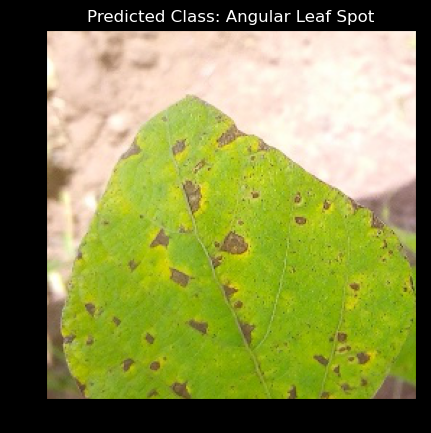

Angular Leaf Spot


In [549]:
test_ind = np.random.randint(0,test_images.shape[0])
plt.imshow(test_images[test_ind])
plt.gcf().set_facecolor('black')
plt.title('Predicted Class: '+str(class_to_label[int(predictions[test_ind].argmax())]),color='white')
plt.show()
actual_pred = class_to_label[test_labels[test_ind].argmax()]
print(actual_pred)

In [599]:
features = model.layers[0].weights[0].numpy()
features.shape
filtered_im = np.dstack([filter2D(test_images[test_ind,:,:,k],kernel=5*features[:,:,k,13], ddepth=-1) for k in range(3)])
def relu(arr):
    for i in range(3):
        for j in range(256):
            for k in range(256):
                if arr[j,k,i]<0:
                    arr[j,k,i] = 0
    return arr


0.51350594

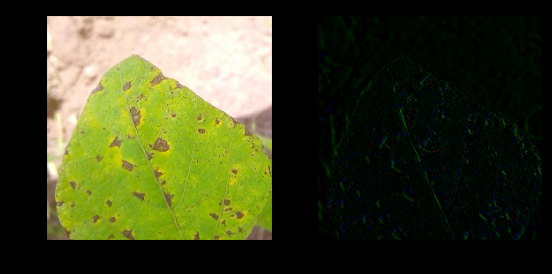

In [600]:
fig, ax = plt.subplots(1,2)
fig.set_facecolor('black')
ax[0].imshow(relu(test_images[test_ind]))
ax[1].imshow(relu(filtered_im))
np.max(relu(filtered_im))

In [583]:
features = [filter2D(test_images[test_ind],kernel=features[:,:,:,i],ddepth=-1)for i in range(32)]

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\count_non_zero.dispatch.cpp:124: error: (-215:Assertion failed) cn == 1 in function 'cv::countNonZero'
